In [76]:
import scanpy as sc
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

plt.rcParams['figure.figsize']=(3,3)

In [77]:
title="q_con"

path="/home/hpc/lianyun.huang/singlecell/final4"
path_data="/project/genomics/lianyun/CaIPACL/cp_from_homepath/data_final4"
pathout_qc=path+"/output/output_qc"
pathout_scanorama=path+"/output/output_scanorama"


path_sample1 = path_data + "/soupx_scrublet_sample" + "11" + ".h5ad"
path_sample2 = path_data + "/soupx_scrublet_sample" + "12" + ".h5ad"
path_sample3 = path_data + "/soupx_scrublet_sample" + "13" + ".h5ad"

path_sample4 = path_data + "/soupx_scrublet_sample" + "19" + ".h5ad"
path_sample5 = path_data + "/soupx_scrublet_sample" + "20" + ".h5ad"
path_sample6 = path_data + "/soupx_scrublet_sample" + "21" + ".h5ad"

# finalsoupx_sample, soupx_scrublet_sample

In [78]:
sample1 = sc.read_h5ad(path_sample1)
sample2 = sc.read_h5ad(path_sample2)
sample3 = sc.read_h5ad(path_sample3)

sample4 = sc.read_h5ad(path_sample4)
sample5 = sc.read_h5ad(path_sample5)
sample6 = sc.read_h5ad(path_sample6)


sample1.obs["status"]="con"
sample2.obs["status"]="con"
sample3.obs["status"]="con"

sample4.obs["status"]="q"
sample5.obs["status"]="q"
sample6.obs["status"]="q"



adata = sample1.concatenate(sample2,sample3,sample4,sample5,sample6)
adata.obs=adata.obs.drop(["doublet","doublet_score"],axis=1)

/home/hpc/lianyun.huang/anaconda3/envs/xyb/lib/python3.11/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [79]:
batch1 = adata[adata.obs["batch"] == "0", :]
batch2 = adata[adata.obs["batch"] == "1", :]
batch3 = adata[adata.obs["batch"] == "2", :]

batch4 = adata[adata.obs["batch"] == "3", :]
batch5 = adata[adata.obs["batch"] == "4", :]
batch6 = adata[adata.obs["batch"] == "5", :]


split = [batch1,batch2,batch3,batch4,batch5,batch6]

### normalization

In [80]:
adata.X = adata.layers["soupX_counts"].copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers["logcounts"] = adata.X.copy()

/home/hpc/lianyun.huang/anaconda3/envs/xyb/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


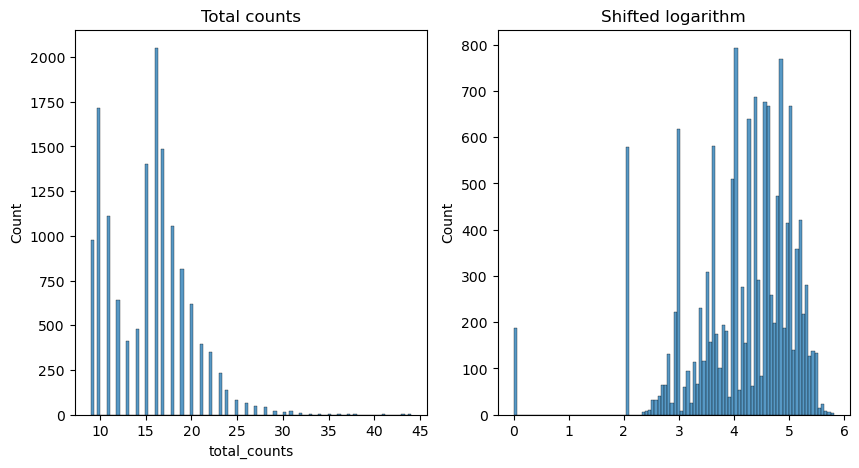

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sb.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sb.histplot(adata.layers["logcounts"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.savefig(pathout_qc+"/combine_normalization_"+title+".pdf")

plt.show()

### before batch correction

In [82]:
adata_nocorrection = adata.copy()

sc.pp.highly_variable_genes(adata_nocorrection)
sc.tl.pca(adata_nocorrection)
sc.pp.neighbors(adata_nocorrection)
sc.tl.umap(adata_nocorrection)
adata_nocorrection

AnnData object with n_obs × n_vars = 14197 × 342
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'status', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'n_cells-1', 'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'log1p_total_counts-2', 'n_cells-2', 'n_cells_by_counts-3', 'mean_counts-3', 'log1p_mean_counts-3', 'pct_dropout_by_counts-3', 'total_counts-3', 'log1p_total_counts-3', 'n_cells-3', 'n_cells_by_counts-4', 'mean_counts-4', 'log1p_mean_counts-4', 'pct_dropout_by_counts-4'

/home/hpc/lianyun.huang/anaconda3/envs/xyb/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


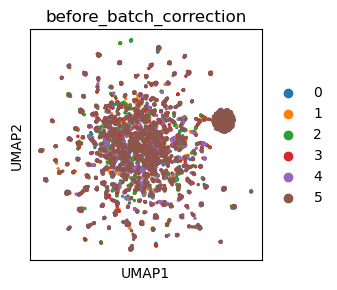

In [83]:
with plt.rc_context():  # Use this to set figure params like size and dpi
    sc.pl.umap(adata_nocorrection,color="batch",size=25,title="before_batch_correction",show=False)
    plt.savefig(pathout_scanorama+"/batchbefore_"+title+".pdf", bbox_inches="tight")

### scanorama

In [84]:
def runScanorama(adata, hvg = None):
    import scanorama
    corrected = scanorama.correct_scanpy(split, return_dimred=True)
    corrected = corrected[0].concatenate(corrected[1:])
    return corrected

In [85]:
adata_scanorama=runScanorama(adata,hvg=None)

Found 342 genes among all datasets
[[0.         0.8042328  0.68888889 0.52063492 0.50952381 0.51058201]
 [0.         0.         0.70394737 0.58727188 0.56106692 0.53720168]
 [0.         0.         0.         0.65930451 0.63580827 0.62077068]
 [0.         0.         0.         0.         0.76446125 0.71505376]
 [0.         0.         0.         0.         0.         0.80529954]
 [0.         0.         0.         0.         0.         0.        ]]
Processing datasets (4, 5)
Processing datasets (0, 1)
Processing datasets (3, 4)
Processing datasets (3, 5)
Processing datasets (1, 2)
Processing datasets (0, 2)
Processing datasets (2, 3)
Processing datasets (2, 4)
Processing datasets (2, 5)
Processing datasets (1, 3)
Processing datasets (1, 4)
Processing datasets (1, 5)
Processing datasets (0, 3)
Processing datasets (0, 5)
Processing datasets (0, 4)


/home/hpc/lianyun.huang/anaconda3/envs/xyb/lib/python3.11/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [86]:
sc.pp.highly_variable_genes(adata_scanorama)
sc.tl.pca(adata_scanorama)
sc.pp.neighbors(adata_scanorama)
sc.tl.umap(adata_scanorama)

/home/hpc/lianyun.huang/anaconda3/envs/xyb/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


/home/hpc/lianyun.huang/anaconda3/envs/xyb/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


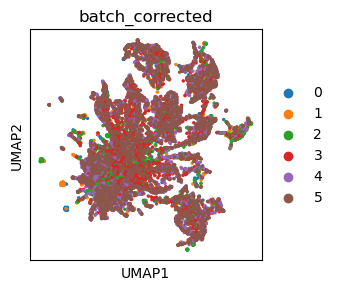

In [87]:
with plt.rc_context():  # Use this to set figure params like size and dpi
    sc.pl.umap(adata_scanorama,color="batch",size=25,title="batch_corrected",show=False)
    plt.savefig(pathout_scanorama+"/batchafter_"+title+".pdf", bbox_inches="tight")

In [88]:
# move visualiztion components into adata
adata.var['highly_variable']=adata_scanorama.var['highly_variable']
adata.var['means']=adata_scanorama.var['means']
adata.var['dispersions']=adata_scanorama.var['dispersions']
adata.var['dispersions_norm']=adata_scanorama.var['dispersions_norm']
adata.uns['hvg']=adata_scanorama.uns['hvg']
adata.uns['pca']=adata_scanorama.uns['pca']
adata.uns['neighbors']=adata_scanorama.uns['neighbors']
adata.uns['umap']=adata_scanorama.uns['umap']
adata.uns['batch_colors']=adata_scanorama.uns['batch_colors']
adata.obsm['X_scanorama']=adata_scanorama.obsm['X_scanorama']
adata.obsm['X_pca']=adata_scanorama.obsm['X_pca']
adata.obsm['X_umap']=adata_scanorama.obsm['X_umap']
adata.varm['PCs']=adata_scanorama.varm['PCs']
adata.obsp['distances'] = adata_scanorama.obsp['distances']
adata.obsp['connectivities'] = adata_scanorama.obsp['connectivities']

In [89]:
adata.X=adata.layers["soupX_counts"].copy()

In [90]:
adata.write(path_data+"/combine_"+title+".h5ad")

In [91]:
print(title)
print(adata.obs["status"].cat.categories)
adata

q_con
Index(['con', 'q'], dtype='object')


AnnData object with n_obs × n_vars = 14197 × 342
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'status', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'n_cells-1', 'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'log1p_total_counts-2', 'n_cells-2', 'n_cells_by_counts-3', 'mean_counts-3', 'log1p_mean_counts-3', 'pct_dropout_by_counts-3', 'total_counts-3', 'log1p_total_counts-3', 'n_cells-3', 'n_cells_by_counts-4', 'mean_counts-4', 'log1p_mean_counts-4', 'pct_dropout_by_counts-4'